In [1]:
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn import metrics
from copy import deepcopy
from PIL import Image
import pandas as pd
import numpy as np
import torchvision
import random
import torch

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

#### Create a Transforms class. This is a set up transformations that you want to apply to each image in your dataset. The ToTensor and CenterCrop transforms are required and the Normalize transform is recommended. ALl other transforms are up to you to choose. See a list of transforms here: https://pytorch.org/vision/stable/transforms.html. Another fun site for transofmrs is here: https://imgaug.readthedocs.io/en/latest/

In [3]:
tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#### Create a dataloader class. This will store all of the imagery of individual schools in your dataset along with their associated test scores. It will handle splitting the data into training and validation sets and converting the sets into PyTorch's Dataloader format.

In [4]:
class Dataloader():
    
    def __init__(self, country, imagery_direc, scores_df, split, batch_size, tfs = None):
        """
        Arguments:
            country: one of ['mex', 'slv', 'peru', 'phl']
            imagery_direc: path to folder containing school imagery
            scores_df: path to CSV file with school IDs and test scroes
            split: train/test split, should be between .01 and 1, recommended is between .65 and .8
            batch_size: number of images in a batch
        """
        self.country = country
        self.imagery_direc = imagery_direc
        self.imagery = os.listdir(self.imagery_direc)
        self.imagery = [i for i in self.imagery if self.country in i]
        self.scores_df = pd.read_csv(scores_df)
        self.scores_df = self.scores_df[self.scores_df['country'] == self.country]
        self.split = split
        self.batch_size = batch_size
        
        if tfs is None:
            self.tfs = transforms.ToTensor()
        else:
            self.tfs = tfs
        
        # Load the data into a list with the format [(school_image, school_test_score), ...]
        self.data = self.load_data()
        
        # Split the data into training and validation sets
        self.train, self.val = self.test_train_split()
        
        
    def load_data(self):
        """
        Load the imagery into a list in the format: [(imager_tensor, test_score), ...]
        """
        data = []
        for col, row in self.scores_df.iterrows():
            school_id = str(row.school_id)
            test_score = row.scaled_score
            impath = [i for i in self.imagery if school_id in i]
            if len(impath) > 0:
                image = np.array(Image.open(self.imagery_direc + impath[0]))
                image = self.tfs(image)
                data.append((image, test_score))
        return data
                
        
    def test_train_split(self):
        """
        Split the data into 4 parts:
            x_train: imagery we use to train the model
            y_train: test_scores matched to the iamgery in x_train
            x_val: imagery used to test the model
            y_val: test_scores matched to the iamgery in x_val
        """
        train_num = int(len(self.data) * self.split)
        val_num = int(len(self.data) - train_num)

        all_indices = list(range(0, len(self.data)))
        train_indices = random.sample(range(len(self.data)), train_num)
        val_indices = list(np.setdiff1d(all_indices, train_indices))

        x_train, x_val = [self.data[i][0] for i in train_indices], [self.data[i][0] for i in val_indices]
        y_train, y_val = [self.data[i][1] for i in train_indices], [self.data[i][1] for i in val_indices]
        
        train = [(k,v) for k,v in zip(x_train, y_train)]
        val = [(k,v) for k,v in zip(x_val, y_val)]

        # Load the data into pytorch's Dataloader format
        train = torch.utils.data.DataLoader(train, batch_size = self.batch_size, shuffle = True, drop_last = True)
        val = torch.utils.data.DataLoader(val, batch_size = self.batch_size, shuffle = True, drop_last = True)

        return train, val

In [5]:
COUNTRY = "mex"
BATCH_SIZE = 4
SPLIT = .75
IMAGERY_DIREC = "../../CCI/hmbaier/"
SCORES_DF = "../../CCI/hmbaier/cci_example.csv"

In [6]:
data = Dataloader(country = COUNTRY, 
                  imagery_direc = IMAGERY_DIREC, 
                  scores_df = SCORES_DF,
                  split = SPLIT,
                  batch_size = BATCH_SIZE,
                  tfs = tfs)
train_dl, val_dl = data.train, data.val

#### Plot a couple sample images from the dataset

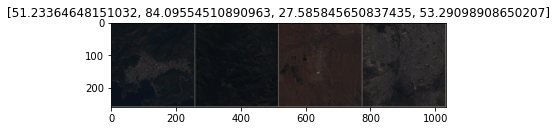

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    
train_features, train_labels = next(iter(train_dl))
out = torchvision.utils.make_grid(train_features)
imshow(out, title = [i.item() for i in train_labels])

In [8]:
# We'll use the to keep track of our training stastics (i.e. running training loss, running validation loss, etc...)
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = round(self.sum / self.count, 4)

We're going to use a basic off the shelf Resnet18 pretrained on ImageNet. ImageNet has 1000 classes, which means our last lauyer, the fully connected layer, has an output size of 1000 (each element in the output represents and ImageNet class). In our case, we want an output size of 1, and that number is our predicted test score. We make the change in the second line using ```model.fc = torch.nn.Linear(512, 1)```. After that, we send the model to a 'device'. If your enviroenmt has a GPU avail;abel to it, this will be "cuda" and if not it will be "cpu". We save this device as a variable, because later on we'll need to send our input images and target test_score tensors to the same device.

In [9]:
# Set up a basic off the shelf 
model = models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(512, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
epochs = 1
dataloader = {'Training': train_dl, 'Validation': val_dl}

#### Set up our hyperparameters
- criterion: Thi sis our loss function. See more options here: https://pytorch.org/docs/stable/nn.html#loss-functions. L1 Loss is basically the same thing as Total Error which means our averaged loss is the smae thing as Mean Average Error (MAE) - note that if you change the type of loss function, the averageed loss will no longer be the MAE
- optimizer: this is how we actually update the weights of our model. See more options here: https://pytorch.org/docs/stable/optim.html#algorithms. --lr is the Learning Rate.
- epochs: The number of epochs to train
- dataloader: Dictionary to help in the training function

In [10]:
def train(dataloader, model, epochs, optimizer, criterion, batch_size, device):
    
    train_tracker, val_tracker = AverageMeter(), AverageMeter()
    trackers = {'Training': train_tracker, "Validation": val_tracker}
    best_mae, best_model_wts = 90000000, model.state_dict()
    
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        
        for phase in ["Training", "Validation"]:
            
            for (inputs, targets) in dataloader[phase]:
                                
                inputs, targets = inputs.to(device), targets.view(-1, 1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                trackers[phase].update(loss.item(), batch_size)
            
                if phase == "Training":
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            print('  {} MAE: {:.4f}'.format(
                phase, trackers[phase].avg))
        
        
        if trackers["Validation"].avg < best_mae:
            best_mae = trackers["Validation"].avg
            best_model_wts = deepcopy(model.state_dict())
            print("  * New best MAE\n")
        else:
            print("\n")
        
        trackers["Training"].reset()
        trackers["Validation"].reset()
        
    model.load_state_dict(best_model_wts)
        
    return model
            
model = train(dataloader, model, epochs, optimizer, criterion, 4, device)

Epoch 0/0
  Training MAE: 25.4178
  Validation MAE: 24.2502
  * New best MAE



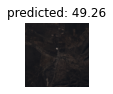

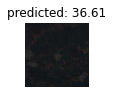

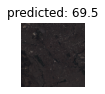

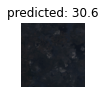

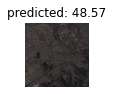

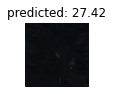

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(round(outputs[j].item(), 2)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)
        
visualize_model(model)

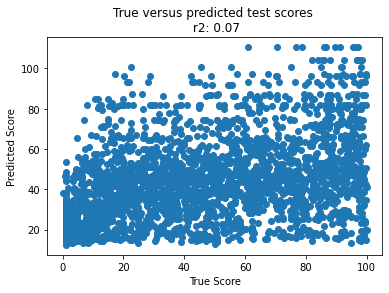

In [12]:
def evaluate_accuracy(model):
    true_scores, predicted_scores = [], []
    model.eval()
    for (inputs, targets) in dataloader['Validation']:
        [true_scores.append(i.item()) for i in targets]
        outputs = model(inputs.to(device))
        [predicted_scores.append(i.item()) for i in outputs]
        
    r2 = round(metrics.r2_score(true_scores, predicted_scores), 2)

    plt.scatter(true_scores, predicted_scores)
    plt.xlabel("True Score")
    plt.ylabel("Predicted Score")
    plt.title(f"True versus predicted test scores \n r2: {r2}")
    plt.show()

evaluate_accuracy(model)

In [13]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
        }, f"./trained_{COUNTRY}_model.torch")